<a href="https://colab.research.google.com/github/mhjalili84/Federated-Learning/blob/main/FD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Federated Knowledge Distillation on MNIST**

Ref: https://arxiv.org/pdf/1811.11479

This project implements Federated Learning via Knowledge Distillation using PyTorch. Instead of sharing private data or model weights, each client trains a teacher model locally on its private dataset and only shares the soft predictions (logits) on a shared public dataset. The server then aggregates these logits to train a compact student model, which is evaluated on a separate test dataset.

**🔍 Key Features:**

Data partitioning using Dirichlet distribution to simulate non-IID client data.

Teacher models trained locally by each client on private data.

Student model trained centrally using the aggregated logits (soft labels).

Privacy-preserving: No raw data or model weights are shared.

Evaluation is performed on a held-out test set (unseen by all clients).

🧪 Dataset
Public + private split of MNIST dataset.

Public data used for distillation.

Private data distributed among clients.

Test data held out for final evaluation.



#Import Liberary

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Set device

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Data Handling

In [53]:
class DataHandler:
    def __init__(self, n_clients=3, dirichlet_alpha=0.5):
        self.n_clients = n_clients
        self.alpha = dirichlet_alpha
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        self.public_size = 5000  # Number of samples used as public data

    def prepare_datasets(self):
        # Load MNIST dataset
        full_train = datasets.MNIST(root='./data', train=True, download=True, transform=self.transform)
        self.test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=self.transform)

        # Split public and private data
        public_data, private_data = random_split(full_train, [self.public_size, len(full_train) - self.public_size])

        # Convert Subset indices to global indices from full_train
        private_indices = np.array(private_data.indices)
        targets = np.array(full_train.targets)[private_indices]

        # Group indices by class
        class_indices = [np.where(targets == i)[0] for i in range(10)]
        client_indices = [[] for _ in range(self.n_clients)]

        # Dirichlet distribution over class samples
        for c in class_indices:
            if len(c) == 0:
                continue
            proportions = np.random.dirichlet(alpha=[self.alpha] * self.n_clients)
            split_sizes = (proportions * len(c)).astype(int)

            # Ensure the total count matches original size
            while split_sizes.sum() < len(c):
                split_sizes[np.argmin(split_sizes)] += 1
            while split_sizes.sum() > len(c):
                split_sizes[np.argmax(split_sizes)] -= 1

            # Shuffle and split
            shuffled = np.random.permutation(c)
            splits = np.split(shuffled, np.cumsum(split_sizes)[:-1])
            for i in range(self.n_clients):
                client_indices[i].extend(private_indices[splits[i]])

        # Create client datasets
        client_datasets = [torch.utils.data.Subset(full_train, indices) for indices in client_indices]

        return public_data, client_datasets


#Model Definitions

In [74]:
class TeacherModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Load ResNet18 pretrained weights
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Modify the first convolutional layer to accept 1-channel input (for MNIST images)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Change the final fully connected layer to output 10 classes (for MNIST)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        return self.resnet(x)



class MobileNetStudentModel(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNetStudentModel, self).__init__()
        self.backbone = models.mobilenet_v2(weights=None)
        # Adjust for grayscale (1-channel) input instead of RGB (3-channel)
        self.backbone.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        # Replace classifier for MNIST output classes
        self.backbone.classifier[1] = nn.Linear(self.backbone.last_channel, num_classes)
        # Optional: Adaptive pooling to handle different input sizes
        self.pool = nn.AdaptiveAvgPool2d((7, 7))

    def forward(self, x):
        # # If input size is 28x28, upsample to 224x224
        # if x.size(-1) == 28:
        #     x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x = self.backbone(x)
        return x


class StudentModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

# Client

In [64]:
class Client:
    def __init__(self, dataset, public_loader):
        self.dataset = dataset
        self.public_loader = public_loader
        self.teacher = TeacherModel().to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.teacher.parameters(), lr=0.001)

    def train_teacher(self, epochs=1):
        loader = DataLoader(self.dataset, batch_size=64, shuffle=True)
        self.teacher.train()
        for _ in range(epochs):
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                self.optimizer.zero_grad()
                out = self.teacher(x)
                loss = self.criterion(out, y)
                loss.backward()
                self.optimizer.step()

    def get_logits(self):
        self.teacher.eval()
        logits = torch.zeros(len(self.public_loader.dataset), 10).to(device)
        with torch.no_grad():
            idx = 0
            for x, _ in self.public_loader:
                x = x.to(device)
                batch_size = x.size(0)
                out = self.teacher(x)
                logits[idx:idx + batch_size] = torch.softmax(out, dim=1)
                idx += batch_size
        return logits

# Server

In [72]:
class Server:
    def __init__(self, public_loader, test_loader):
        self.public_loader = public_loader
        self.test_loader = test_loader
        # self.student = StudentModel().to(device)
        self.student = MobileNetStudentModel().to(device)
        self.optimizer = optim.Adam(self.student.parameters(), lr=0.001)
        self.criterion = nn.KLDivLoss(reduction='batchmean')

    def aggregate_logits(self, logits_list, client_sizes):
        total_samples = sum(client_sizes)
        weighted_logits = sum(
            (size / total_samples) * logits for logits, size in zip(logits_list, client_sizes)
        )
        return weighted_logits

    def train_student(self, global_logits, epochs=1):
        self.student.train()
        total_loss, total_samples = 0, 0

        for _ in range(epochs):
            idx = 0
            for x, y in self.public_loader:
                x, y = x.to(device), y.to(device)
                soft_targets = global_logits[idx:idx + x.size(0)].to(device)
                idx += x.size(0)

                self.optimizer.zero_grad()
                outputs = self.student(x)
                loss = self.criterion(torch.log_softmax(outputs, dim=1), soft_targets)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item() * x.size(0)
                total_samples += x.size(0)

        return total_loss / total_samples

    def evaluate(self):
        self.student.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(device), y.to(device)
                outputs = self.student(x)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        return 100. * correct / total

#  Federated Distillation System

In [71]:
class FederatedDistillationSystem:
    def __init__(self, rounds=5, local_epochs=1, n_clients=3, dirichlet_alpha=0.5):
        self.rounds = rounds
        self.local_epochs = local_epochs
        self.n_clients = n_clients
        self.accuracies = []
        self.losses = []

        self.data_handler = DataHandler(n_clients=n_clients, dirichlet_alpha=dirichlet_alpha)
        public_set, client_sets = self.data_handler.prepare_datasets()

        self.public_loader = DataLoader(public_set, batch_size=64, shuffle=False)
        self.test_loader = DataLoader(self.data_handler.test_dataset, batch_size=128, shuffle=False)
        self.clients = [Client(data, self.public_loader) for data in client_sets]
        self.server = Server(self.public_loader, self.test_loader)

    def run(self):
        for r in range(self.rounds):
            print(f"\n--- Round {r + 1} ---")
            logits_list = []
            client_sizes = []

            for i, client in enumerate(self.clients):
                print(f"Client {i+1}: Training teacher...")
                client.train_teacher(epochs=self.local_epochs)
                logits = client.get_logits()
                logits_list.append(logits)
                client_sizes.append(len(client.dataset))

            global_logits = self.server.aggregate_logits(logits_list, client_sizes)
            print("Server: Training student...")
            loss = self.server.train_student(global_logits, epochs=self.local_epochs)
            acc = self.server.evaluate()

            self.losses.append(loss)
            self.accuracies.append(acc)
            print(f"Round {r+1}: Accuracy = {acc:.2f}%, Loss = {loss:.4f}")


        torch.save(self.server.student.state_dict(), "student_model.pth")
        self.save_results()
        self.plot_metrics()

    def save_results(self):
        df = pd.DataFrame({
            'round': list(range(1, self.rounds + 1)),
            'accuracy': self.accuracies,
            'loss': self.losses
        })
        df.to_csv("results.csv", index=False)
        print("Results saved to results.csv")

    def plot_metrics(self):
        rounds = range(1, self.rounds + 1)
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(rounds, self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy (%)")
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(rounds, self.losses, marker='s', color='red')
        plt.title("Loss per Round")
        plt.xlabel("Round")
        plt.ylabel("Loss")
        plt.grid(True)

        plt.tight_layout()
        plt.savefig("metrics_plot.png")
        plt.show()


# Run System


--- Round 1 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 1: Accuracy = 35.46%, Loss = 1.0427

--- Round 2 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 2: Accuracy = 64.30%, Loss = 0.5161

--- Round 3 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 3: Accuracy = 79.34%, Loss = 0.3675

--- Round 4 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 4: Accuracy = 84.24%, Loss = 0.2995

--- Round 5 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 5: Accuracy = 86.56%, Loss = 0.2699

--- Round 6 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: 

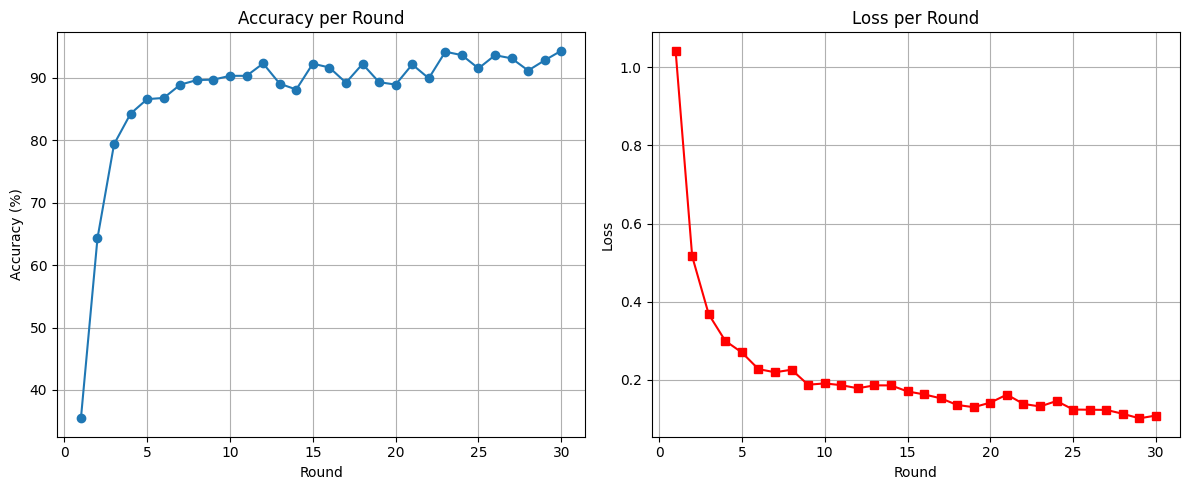

In [77]:
system = FederatedDistillationSystem(rounds=30, local_epochs=1, n_clients=3, dirichlet_alpha=0.1)
system.run()


--- Round 1 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 1: Accuracy = 45.10%, Loss = 1.4268

--- Round 2 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 2: Accuracy = 78.37%, Loss = 0.7484

--- Round 3 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 3: Accuracy = 84.84%, Loss = 0.3900

--- Round 4 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 4: Accuracy = 84.76%, Loss = 0.2217

--- Round 5 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 5: Accuracy = 86.14%, Loss = 0.2093

--- Round 6 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: 

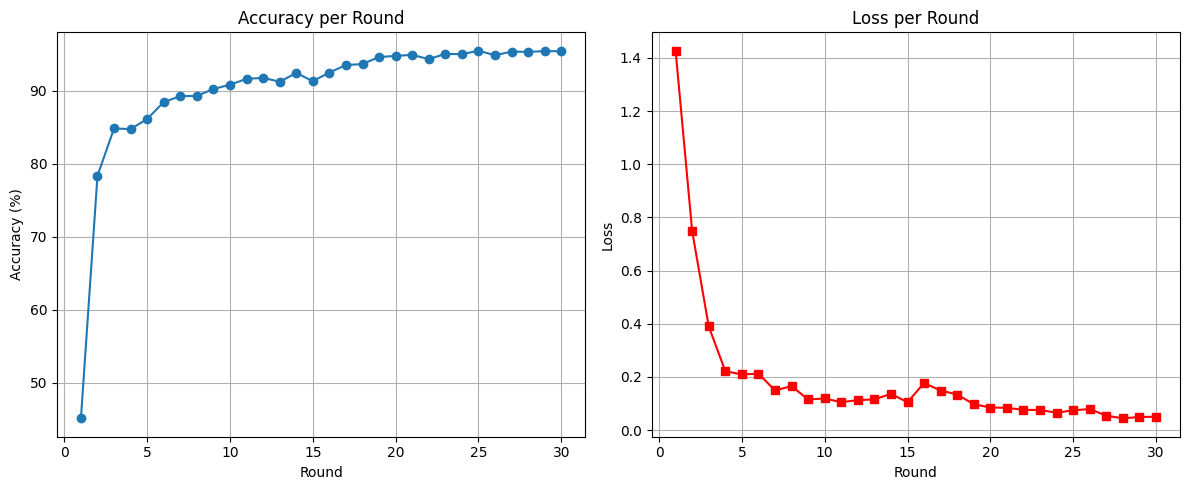

In [75]:
system = FederatedDistillationSystem(rounds=30, local_epochs=1, n_clients=3, dirichlet_alpha=0.5)
system.run()


--- Round 1 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 1: Accuracy = 37.14%, Loss = 1.3823

--- Round 2 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 2: Accuracy = 75.02%, Loss = 0.7760

--- Round 3 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 3: Accuracy = 80.56%, Loss = 0.4390

--- Round 4 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 4: Accuracy = 85.77%, Loss = 0.2778

--- Round 5 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: Training student...
Round 5: Accuracy = 86.52%, Loss = 0.2266

--- Round 6 ---
Client 1: Training teacher...
Client 2: Training teacher...
Client 3: Training teacher...
Server: 

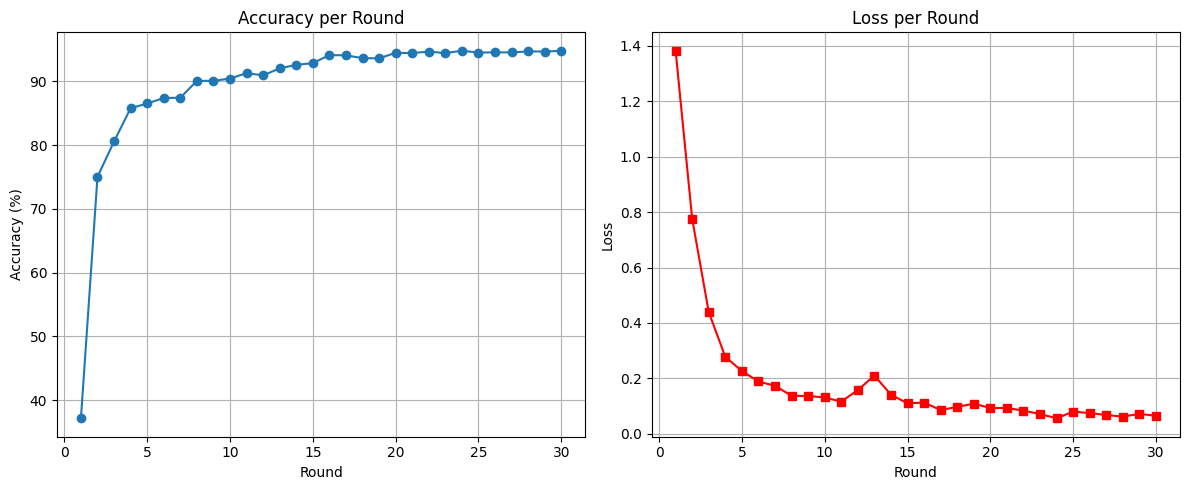

In [76]:
system = FederatedDistillationSystem(rounds=30, local_epochs=1, n_clients=3, dirichlet_alpha=0.7)
system.run()